In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [46]:
data = pd.read_csv('data/NYC_Motor_Vehicle_Collisions_Cleaned.csv')

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928322 entries, 0 to 1928321
Data columns (total 22 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   borough                        object 
 1   zip_code                       object 
 2   latitude                       float64
 3   longitude                      float64
 4   location                       object 
 5   on_street_name                 object 
 6   cross_street_name              object 
 7   off_street_name                object 
 8   number_of_persons_injured      float64
 9   number_of_persons_killed       float64
 10  number_of_pedestrians_injured  int64  
 11  number_of_pedestrians_killed   int64  
 12  number_of_cyclist_injured      int64  
 13  number_of_cyclist_killed       int64  
 14  number_of_motorist_injured     int64  
 15  number_of_motorist_killed      int64  
 16  contributing_factor_vehicle_1  object 
 17  contributing_factor_vehicle_2  object 
 18  co

In [48]:
data['crash_datetime'] = pd.to_datetime(data['crash_datetime'], errors='coerce')

In [49]:
# Extract more granular datetime features
data['month'] = data['crash_datetime'].dt.month
data['day_of_week'] = data['crash_datetime'].dt.day_name()
data['hour'] = data['crash_datetime'].dt.hour
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday'])

In [50]:
def classify_severity(row):
    if row['number_of_persons_killed'] > 0:
        return 'Fatal'
    elif row['number_of_persons_injured'] > 0:
        return 'Injury'
    else:
        return 'Property Damage Only'

data['severity'] = data.apply(classify_severity, axis=1)

In [51]:
data['total_casualties'] = data['number_of_persons_killed'] + data['number_of_persons_injured']

In [52]:
data['is_night'] = data['hour'].apply(lambda x: x < 6 or x > 20)

In [53]:
# Check current values
print(data['severity'].value_counts())

severity
Property Damage Only    1463278
Injury                   462229
Fatal                      2815
Name: count, dtype: int64


In [54]:
data['severity'] = data['severity'].apply(lambda x: 1 if x == 'Injury' or x == 'Fatal' else 0)

### Data Preparation

In [57]:
model_data = data.copy()

In [ ]:
model_data.info()

In [58]:
# Drop columns that won't help the model
drop_cols = ['crash_datetime', 'month', 'hour', 'location', 'day_of_week', 'zip_code', 'collision_id', 'latitude', 'longitude']
model_data.drop(columns=drop_cols, inplace=True, errors='ignore')

In [59]:
leaky_cols = [
    'number_of_persons_injured',
    'number_of_persons_killed',
    'total_casualties',
]
model_data.drop(columns=leaky_cols, inplace=True, errors='ignore')

#### Correlation Analysis

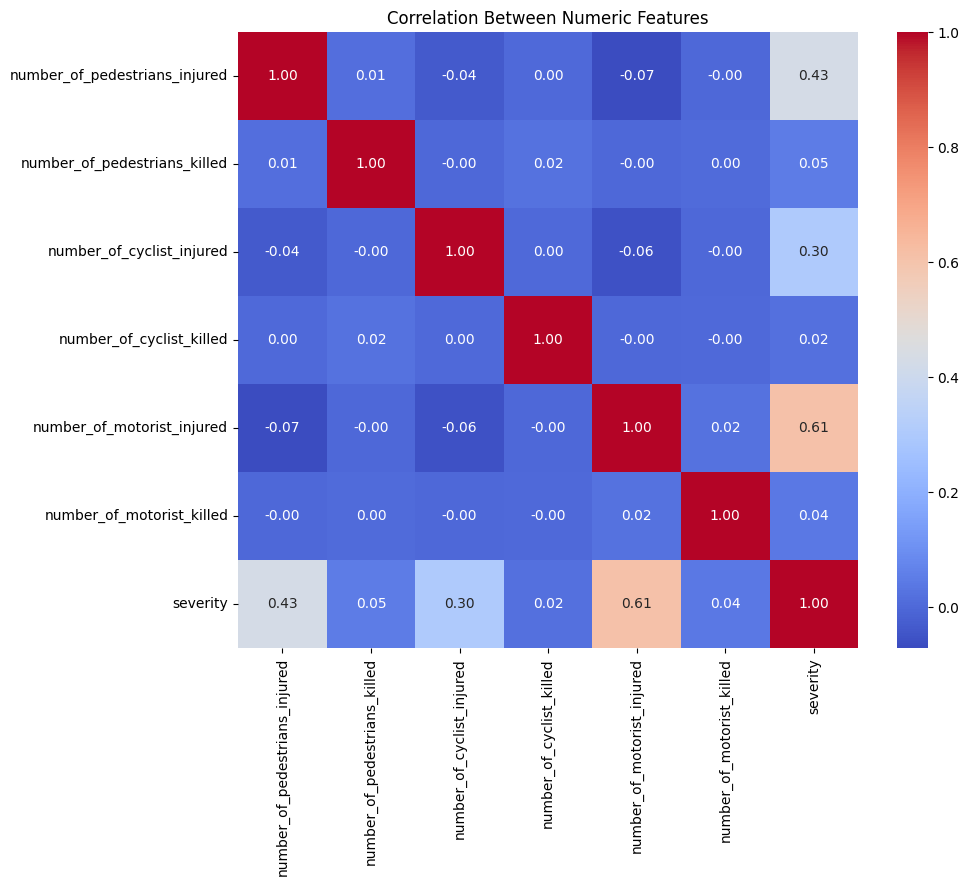

In [60]:
numeric_cols = model_data.select_dtypes(include='number')
plt.figure(figsize=(10,8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Numeric Features')
plt.show()

In [61]:
# Removing highly correlated features
corr_matrix = numeric_cols.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print(f"Features to drop due to high correlation: {to_drop}")

Features to drop due to high correlation: []


In [62]:
model_data.drop(columns=to_drop, inplace=True)

### Encoding the Features

In [63]:
# Encode categorical features (if any)
categorical_cols = model_data.select_dtypes(include=['object', 'category']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    model_data[col] = le.fit_transform(model_data[col])
    label_encoders[col] = le

In [64]:
# drop NA values if any
model_data.dropna(inplace=True)

### Scaling and Splitting

In [66]:
X = model_data.drop('severity', axis=1)
y = model_data['severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [67]:
# Scaling for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
print(y.value_counts(normalize=True))

severity
0    0.758835
1    0.241165
Name: proportion, dtype: float64


### Modeling

In [80]:
# Model Evaluation Function
def evaluate_model(model, X_train, X_test, scale=False):
    if scale:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{'='*30}\n{model.__class__.__name__} Evaluation")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

#### Logistic Regression

In [81]:
log_reg = LogisticRegression()
evaluate_model(log_reg, X_train, X_test, scale=True)


LogisticRegression Evaluation
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    292656
           1       1.00      0.98      0.99     93009

    accuracy                           1.00    385665
   macro avg       1.00      0.99      0.99    385665
weighted avg       1.00      1.00      1.00    385665

ROC-AUC Score: 0.9965834600679911
Confusion Matrix:
[[292624     32]
 [  1613  91396]]


In [82]:
dt = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced')
evaluate_model(dt, X_train, X_test)


DecisionTreeClassifier Evaluation
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    292656
           1       1.00      0.98      0.99     93009

    accuracy                           1.00    385665
   macro avg       1.00      0.99      0.99    385665
weighted avg       1.00      1.00      1.00    385665

ROC-AUC Score: 0.9956309370850861
Confusion Matrix:
[[292624     32]
 [  1766  91243]]


In [ ]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')
evaluate_model(rf, X_train, X_test)